In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing
import torch
from torch import nn 

In [2]:
from utils import *

In [3]:
arms = torch.tensor([[ 0.6667,  0.3333, -0.6667], [-0.2182,  0.8729, -0.4364]]).float()

In [4]:
bandit = GradientBandit(n_arms=2, context_size=2)
non_strat = Agents(n=1000, n_arms=2, context_size=2,
                  arms=arms,
                  max_reward=0, max_variance=0)

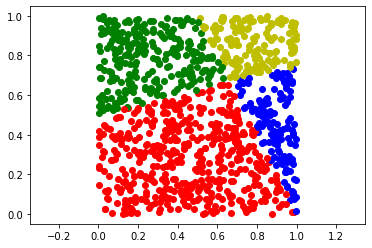

In [5]:
plt.axis('equal')
for i in range(len(non_strat)):
    x, y, var = non_strat[i]
    plt.scatter(x[0], x[1], c='r' if y[0] < 0 and y[1] < 0 else 'g' if y[0] < 0 and y[1] >= 0 else 'b' if y[0] >= 0 and y[1] < 0 else 'y')

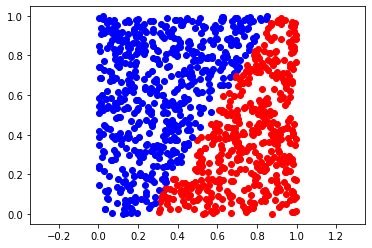

In [12]:
plt.axis('equal')
x_aug = torch.cat([non_strat.x, torch.ones(len(non_strat.x)).reshape(-1, 1)], 1).float()
ys = torch.max(x_aug @ arms.T, dim=-1).indices
for i in range(len(non_strat)):
    x, y, var = non_strat[i]
    plt.scatter(x[0], x[1], c='r' if ys[i] == 0 else 'b')